In [27]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [31]:
cd drive/MyDrive/Colab/Style\ Transfer

[Errno 2] No such file or directory: 'drive/MyDrive/Colab/Style Transfer'
/content/drive/MyDrive/Colab/Style Transfer


## 使用TF_hub所提供的style transfer來快速玩看看

程式碼修改自:
https://www.tensorflow.org/tutorials/generative/style_transfer

本例中將使用TF-Hub上的預訓練模型去實作可輸入任意維度尺寸的Fast Style Transfer(2017)風格轉換

TF-Hub介紹 https://www.tensorflow.org/hub?hl=zh-tw

### 載入所需使用*模組* 與 *相關配置*

In [1]:
#標準配備
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

#使用PIL來作影像的操作
import PIL.Image

#匯入tensorflow
import tensorflow as tf

#量測程式執行時間用
import time

#載入 tensorflow hub範例
import tensorflow_hub as hub


In [18]:
#讓影像顯示大一點
mpl.rcParams['figure.figsize'] = (12,12) #畫布尺寸
mpl.rcParams['axes.grid'] = False # 不顯示格線

### 下載風格與待轉換影像

`tf.keras.utils.get_file('檔名','網址')` 功能為下載網路上檔案, 並且存檔

In [3]:
content_path = tf.keras.utils.get_file('content_autumn.jpg', 'https://upload.wikimedia.org/wikipedia/commons/1/12/Autumn_scene_at_Woodleigh_%286_of_7%29.jpg')
style_path = tf.keras.utils.get_file('style_winter.jpg','https://upload.wikimedia.org/wikipedia/commons/3/32/20190111_Sninsky_kamen.jpg')

2195456/2190308 [==============================] - 0s 0us/step


In [19]:
# 列印出目前要處理檔案路徑
print(content_path)
print(style_path)

/root/.keras/datasets/content_autumn.jpg
/root/.keras/datasets/style_winter.jpg


## 讀入影像的函數

#### 依比例縮放影像, 最大維度為 *512*

實際上TF-Hub接受輸入任意維度影像，此處限制影像最大維度大小是為了避免計算時間過久

In [20]:
#將讀取影像、數值縮放和影像尺寸調整都包成一個函數
#後續使用時，直接用load_img呼叫即可。

def load_img(path_to_img):
    max_dim = 512
    
    # 讀取影像
    img = tf.io.read_file(path_to_img) # 讀取影像至tf上
    img = tf.image.decode_image(img, channels=3) # 解碼影像(將類似0x7b轉換為對應影像數值)
    
    img = tf.image.convert_image_dtype(img, tf.float32) # 轉換數值範圍至[0,1)

    # 計算縮放比例
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)    #-1是用來不考慮尾端的chaanel，再進行影像尺寸計算
    long_dim = max(shape)       #算出長軸的維度
    scale = max_dim / long_dim  #算出縮放的比例
    
    # 計算依比例縮放後維度
    new_shape = tf.cast(shape * scale, tf.int32)   
    
    # 影像縮放
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]    #用tf.newaxis將batch的維度加上去
    return img


#重點一: Tensor影像數值為 0~1 之間的浮點數
#重點二: 最終維度為 batch, image_dim, channel

## 讀入影像、觀察尺寸

In [21]:
#透過前述的load_img將影像讀入
content_image = load_img(content_path)
style_image = load_img(style_path)


In [22]:
#直接印出來觀察影像內容
#content_image
print(content_image.shape)
#print(content_image[0].shape)

(1, 512, 484, 3)


In [23]:
type(content_image)

tensorflow.python.framework.ops.EagerTensor

補充

tf可分為`Eager mode` 與 `Graph mode`

tf 2.x 以後預設為`Eager mode`

故印出來型態為tf.EagerTensor

此為tf的`eager mode`的Tensor

tf的Tensor為無狀態版本的tf.Variable, 常見狀態例如: trainable 

常見Tensor:
* EagerTensor - tf2.x後預設的Tensor
* RaggedTensor - 任意長度尺寸版本的Tensor
* SparseTensors - 稀疏版本的Tensor

## 顯示影像函式

In [24]:
#將顯示影像包成一個函數
#直接用imshow就可以show出影像

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)    #去掉batch所在的維度

    plt.imshow(image)
    if title:
        plt.title(title)       #顯示title在圖片上方
        

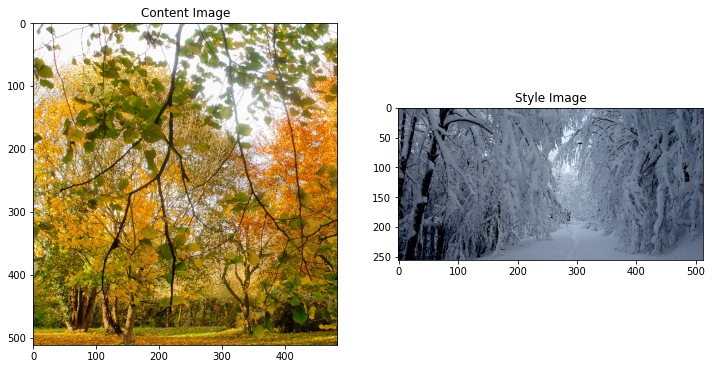

In [25]:
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

#### 放入自己喜歡的內容和風格吧：(Content Image和Style Image)

##### 練習一: 嘗試修改使用不同的影像網址試試看

##### 提示: 使用 `tf.keras.utils.get_file` 時, 除了修改網址, 記得要更改檔名, 因為有快取機制, 若偵測到檔案已經存在就不會重複下載

In [11]:
# content_path = tf.keras.utils.get_file('content_autumn.jpg', '網址')
# style_path = tf.keras.utils.get_file('style_winter.jpg','網址')

# content_image = load_img(content_path)
# style_image = load_img(style_path)

##### 練習二: 嘗試讀入自己想要的圖片

##### 提示:  把圖片放到同個資料夾後，直接用load_img呼叫就好(或是用之前介紹的方法)
##### 例如:load_img('stylized-image_pk.png')

In [32]:
content_image = load_img('MarsPerseverance.jpg')
style_image = load_img('Summer.jpg')

# 執行風格轉換 使用 TF-Hub

## 實際風格轉換程式

載入TF-Hub上的風格轉換預訓練模型, 

此為Fast Style Transfe實作[1]

[1] Golnaz Ghiasi, Honglak Lee, Manjunath Kudlur, Vincent Dumoulin, Jonathon Shlens. Exploring the structure of a real-time, arbitrary neural artistic stylization network. Proceedings of the British Machine Vision Conference (BMVC), 2017.



In [33]:
# 載入TF-Hub上的風格轉換預訓練模型,
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

執行風格轉換

In [34]:
%%time
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]

#加上 %%time可以知道這個區塊的執行時間

CPU times: user 4.45 s, sys: 89.9 ms, total: 4.54 s
Wall time: 2.7 s


練習:

1. TF-HUB上有提供兩個版本的預訓練模型, 試比較其差異

https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1

https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2


### 顯示風格轉換後影像

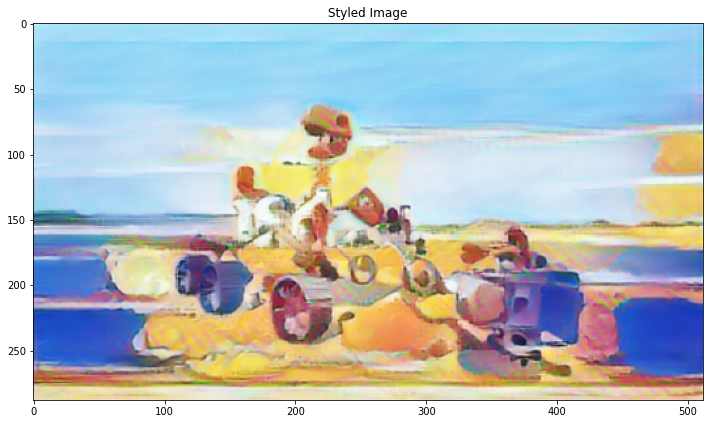

In [35]:
imshow(stylized_image, 'Styled Image')

## 輸出存檔

In [16]:
#前面都是用tf的格式，這邊需要作檔案格式轉換
#將tf網路變數(tf.Tensor)轉換成PIL格式影像(可想像成帶有檔頭的numpy array)
#這樣後面可以直接用PIL的存檔功能

def tensor_to_image(tensor):
    #將tensor格式(0~1)轉為0~255的影像
    tensor = tensor*255   #
    tensor = np.array(tensor, dtype=np.uint8)   #轉換成int的array
    
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1         #削掉batch
        tensor = tensor[0]
        
    return PIL.Image.fromarray(tensor)      #回傳PIL的格式

In [17]:
#將風格轉換後的照片存檔
file_name = 'stylized-image.png'
tensor_to_image(stylized_image).save(file_name)

## 延伸思考: (補充)

前述所建立完整風格影像轉換程式碼, 利用諸如Flask, Django, FastAPI等，可做為Web-based的API

然實務應用中, 基於隱私等原因, 不方便將照片傳輸出去, 需於邊緣裝置上執行

故實作基於邊緣裝置亦是一研究課題

下例中為手機裝置(Android與iOS)範例程式

https://github.com/tensorflow/examples/tree/master/lite/examples/style_transfer

將風格轉換模型拆分為兩模型(Style predict model與Style transform model)進行實作, 如此於邊緣裝置上這樣做的優點/效益是什麼?


![image.png](attachment:image.png)